# Colorspace exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imagine.color import conversion

In [2]:
df = pd.read_csv("preprocessed/colors.csv", na_values=-1).dropna().convert_dtypes()
df

id  skin_r  skin_g  skin_b  hair_r  hair_g  hair_b  lips_r  \
0    Oqp-lhgDOac     160     134     137      51      40      34     148   
1    _DpQTfNFE7A     154      99      71      26      23      23     154   
2    lh5VYM_EWwY     194     158     142      76      58      43     181   
3    MB38nvK_WVM     198     153     120      20      23      24     179   
4    heQXH5nwGdE     184     138     121      37      25      27     162   
..           ...     ...     ...     ...     ...     ...     ...     ...   
970  3ODmwOXVjfk     208     159     134      31      18      12     181   
971  MbxC1ZGsA3M     209     164     145      39      25      22     181   
972  6XyACOs0xiA     211     144     183      25      17      27     211   
973  JR7lx_kbV88     227     168     147     161     125     105     214   
974  6PBoulQg5QA     227     160     144      56      27      23     209   

     lips_g  lips_b  ...  lipstick_b  eyeshadow0_r  eyeshadow0_g  \
0        91     121  ...         103            88            56   
1        94      82  ...         112            85            61   
2       122     128  ...          98           111            73   
3       118     103  ...         107           116            58   
4        79      86  ...          55           102            63   
..      ...     ...  ...         ...           ...           ...   
970     104     103  ...          98           128            86   
971      96     104  ...          86           113            58   
972      97     155  ...         134            72            50   
973     140     145  ...          75           124            59   
974      97     107  ...         111            95            51   

     eyeshadow0_b  eyeshadow1_r  eyeshadow1_g  eyeshadow1_b  eyeshadow2_r  \
0              54           128            89            81           175   
1              58           113            84            75           176   
2              64           153           107            89           203   
3              48           142            86            66           165   
4              53           174           129           103           219   
..            ...           ...           ...           ...           ...   
970            76           160           114            96           180   
971            50           155            98            83           189   
972            74           114            80           105           196   
973            55           180           105            87           233   
974            54           150            91            86           191   

     eyeshadow2_g  eyeshadow2_b  
0             142           124  
1             131           104  
2             168           148  
3             115            88  
4             173           155  
..            ...           ...  
970           133           111  
971           137           116  
972           148           182  
973           176           153  
974           123           110  

[972 rows x 25 columns]

In [3]:
def show_row(row, scale=2):
    def show_color(color_array, name, axis):
        axis.imshow([[color_array]])
        axis.set_title(name)
        axis.set_axis_off()
        
    n = len(row) // 3
    
    fig, axs = plt.subplots(1, n, figsize=(n*scale, scale))
    fig.suptitle(row[0])
    for i in range(n):
        color = row[3*i + 1 : 3*i + 4]
        show_color(np.array(color, dtype=np.uint8), color.index[0].partition('_')[0], axs[i])
        
    plt.tight_layout()
    plt.show()

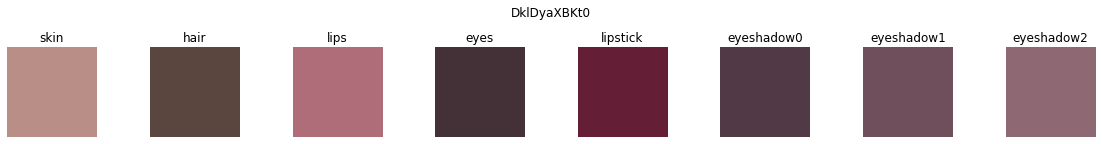

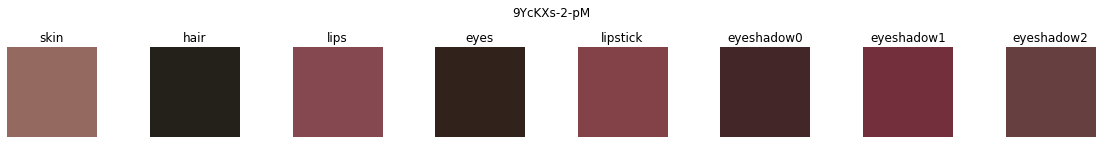

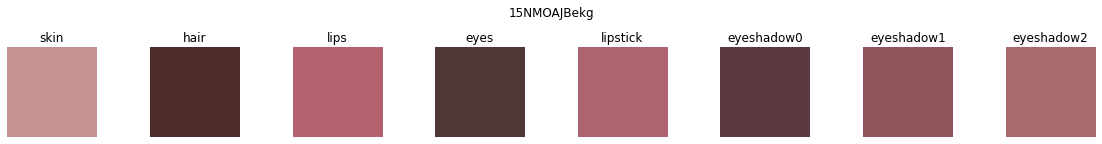

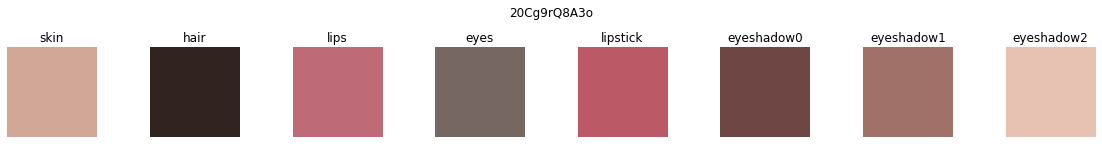

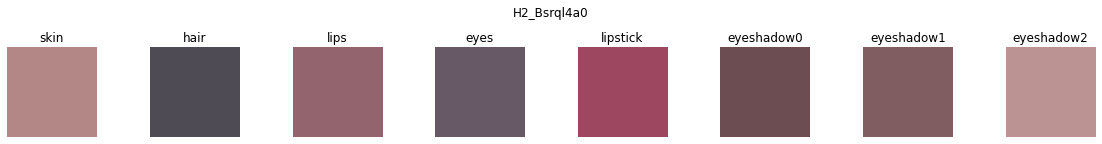

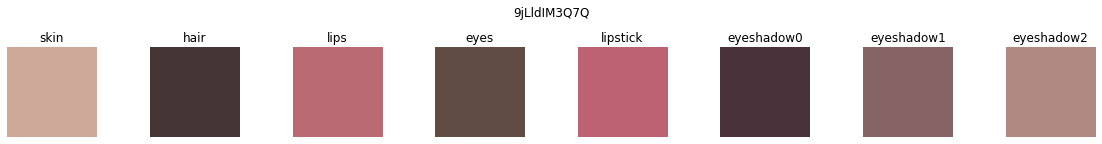

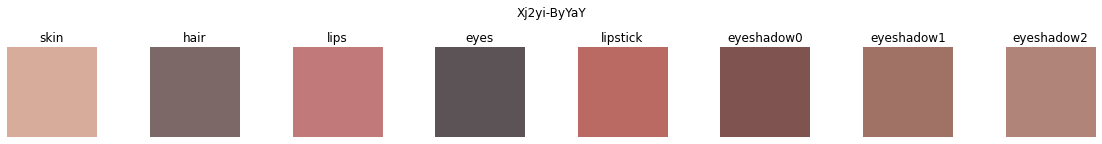

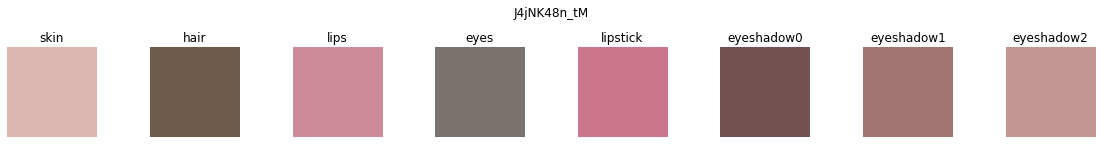

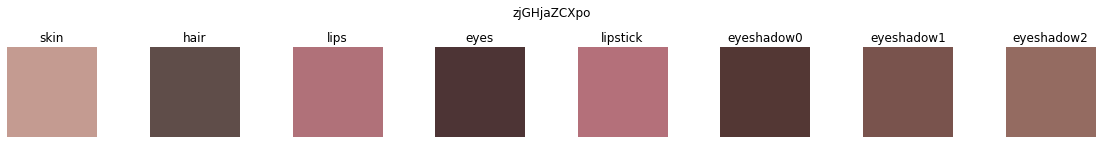

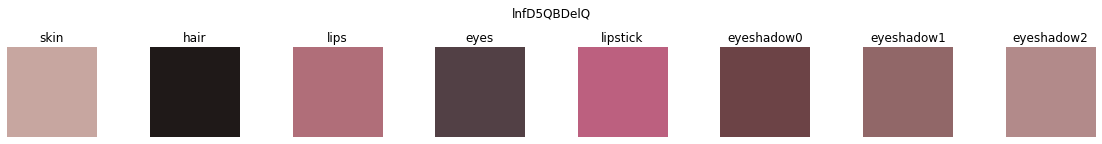

In [4]:
for _, row in df.sample(10).iterrows():
    show_row(row)

In [5]:
parts = {
    "skin" : df.iloc[:, 1:4],
    "hair" : df.iloc[:, 4:7],
    "lips" : df.iloc[:, 7:10],
    "eyes" : df.iloc[:, 10:13],
    "lipstick" : df.iloc[:, 13:16],
    "eyeshadow" : df.iloc[:, 16:19]
}

face_parts = {p: parts[p] for p in ["skin", "hair", "lips", "eyes"]}
makeup_parts = {p: parts[p] for p in ["lipstick", "eyeshadow"]}

In [6]:
def rgb_to_lab_df(df):
    lookup = ["l", "a", "b"]
    return pd.DataFrame(conversion.RgbToLab(df.values[None, ...].astype(np.uint8))[0],
                        columns=["{}_{}".format(c.partition('_')[0], lookup[i]) for i, c in enumerate(df.columns)],
                        index=df.index)

In [7]:
lab_parts = {k: rgb_to_lab_df(v) for k,v in parts.items()}
face_lab_parts = {p: lab_parts[p] for p in ["skin", "hair", "lips", "eyes"]}
makeup_lab_parts = {p: lab_parts[p] for p in ["lipstick", "eyeshadow"]}

In [8]:
face_columns_lab = ["{}_{}".format(p, c) for p in ["skin", "eyes", "hair", "lips"] for c in ["l", "a", "b"]]
makeup_columns_lab = ["{}_{}".format(p, c) for p in ["lipstick", "eyeshadow0"] for c in ["l", "a", "b"]]

### Space of each color feature

In [9]:
def show_colorspace(pixels, name=None, scale=15):
    pixels_array = np.array(pixels, dtype=np.uint8)
    pixels_lab = conversion.RgbToLab(pixels_array[None, ...])[0]
    
    fig = plt.figure(figsize=(scale, scale))
    if name is not None:
        fig.suptitle(name)
    ax = fig.add_subplot(2, 2, 1, title="L channel histogram", xlabel="L")
    ax.hist(pixels_lab[..., 0], bins=64)
    ax = fig.add_subplot(2, 2, 2, title="LAB color space", projection='3d', 
                         xlabel="A", ylabel="B", zlabel="L")
    ax.scatter(pixels_lab[..., 1], pixels_lab[..., 2], pixels_lab[..., 0], facecolors=pixels_array/255.)
    ax = fig.add_subplot(2, 2, 3, xlabel="A", ylabel="L", ylim=[0,255])
    ax.scatter(pixels_lab[..., 1], pixels_lab[..., 0], facecolors=pixels_array/255.)
    ax = fig.add_subplot(2, 2, 4, xlabel="B", ylabel="L", ylim=[0,255])
    ax.scatter(pixels_lab[..., 2], pixels_lab[..., 0], facecolors=pixels_array/255.)
    plt.tight_layout()
    plt.show()

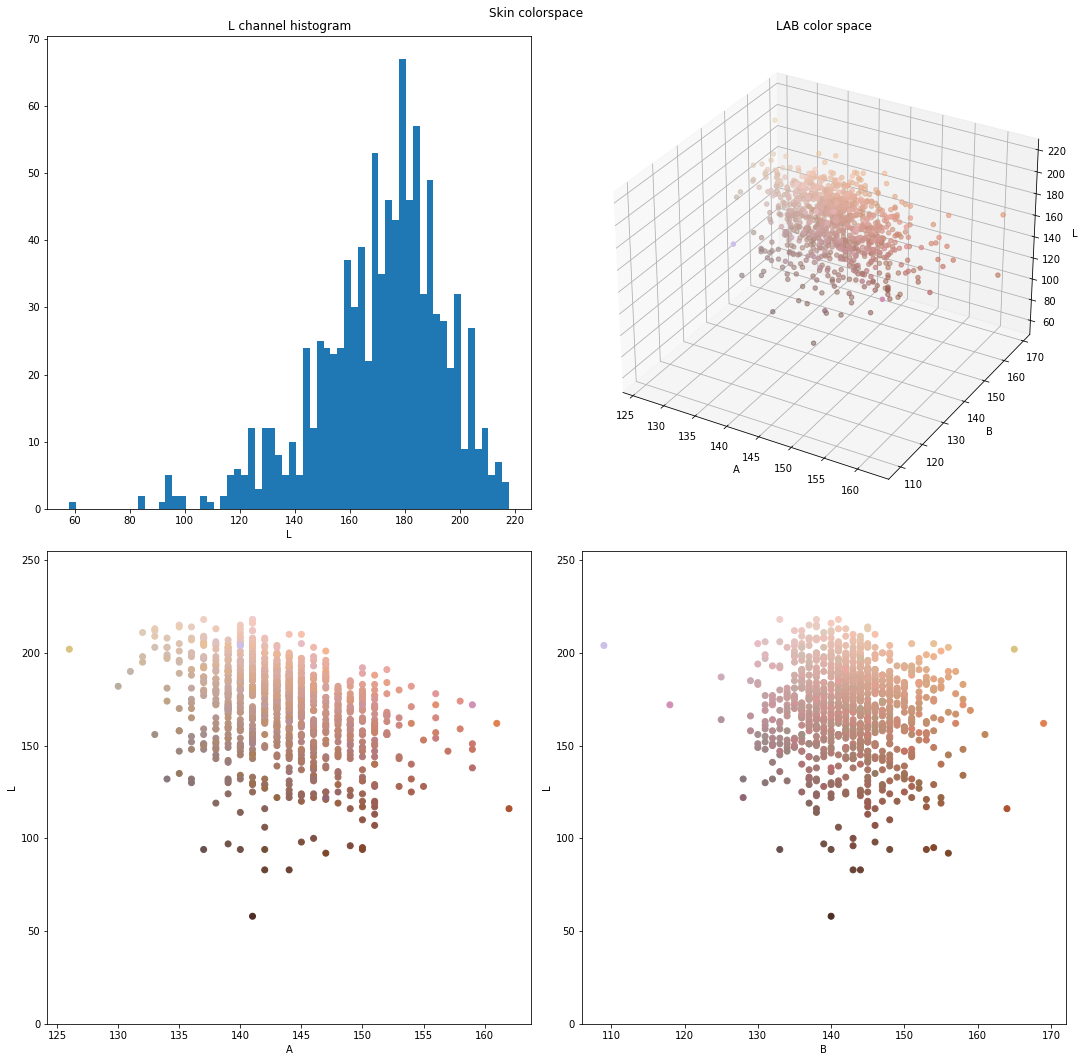

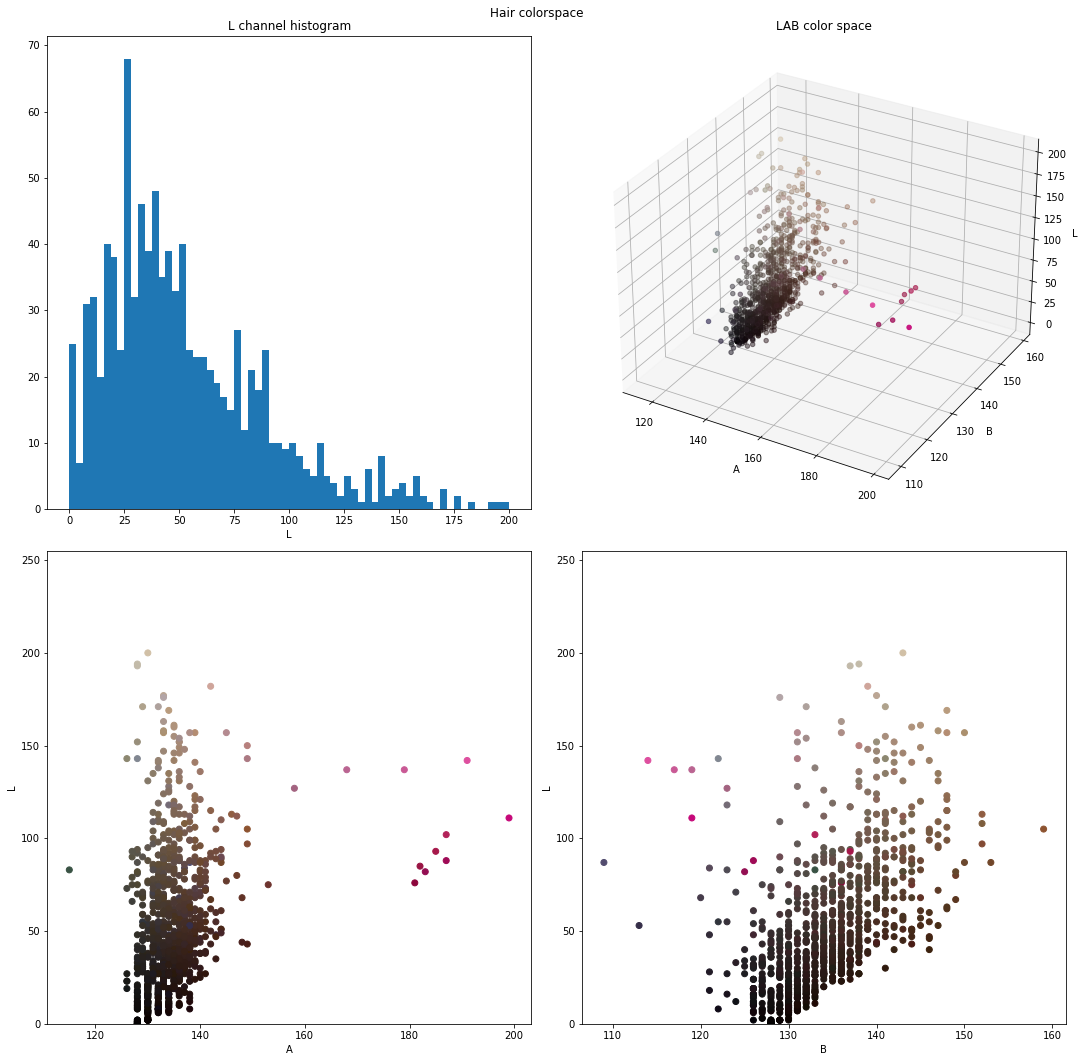

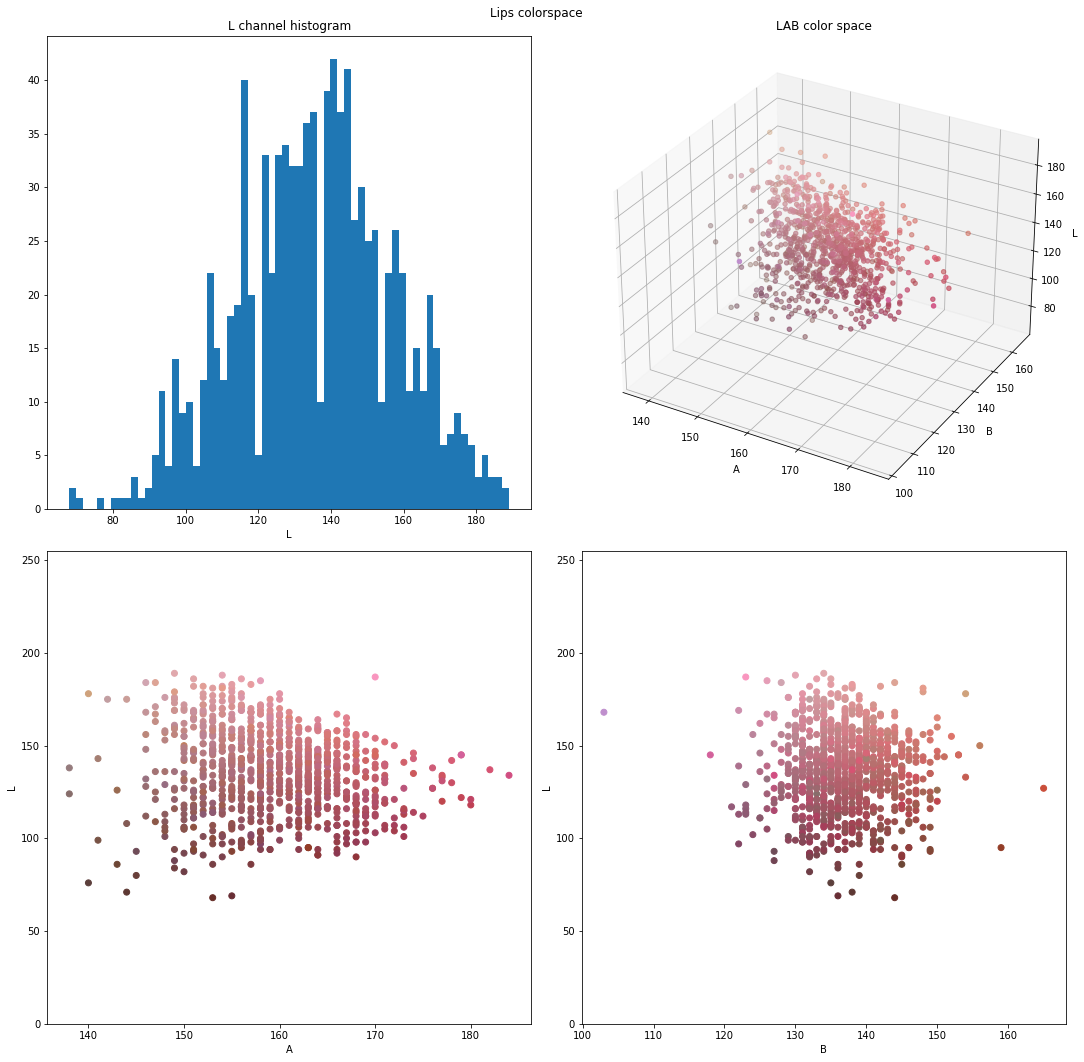

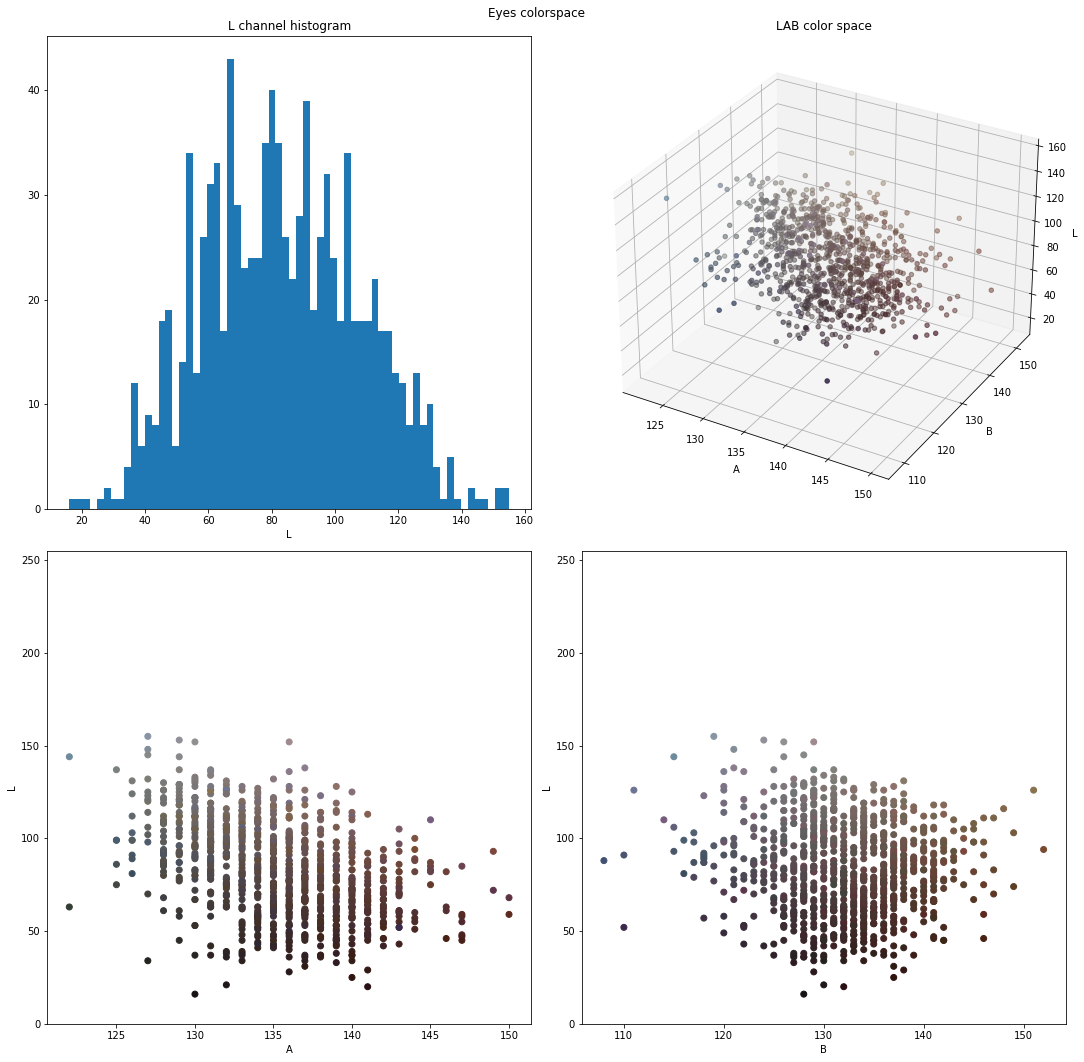

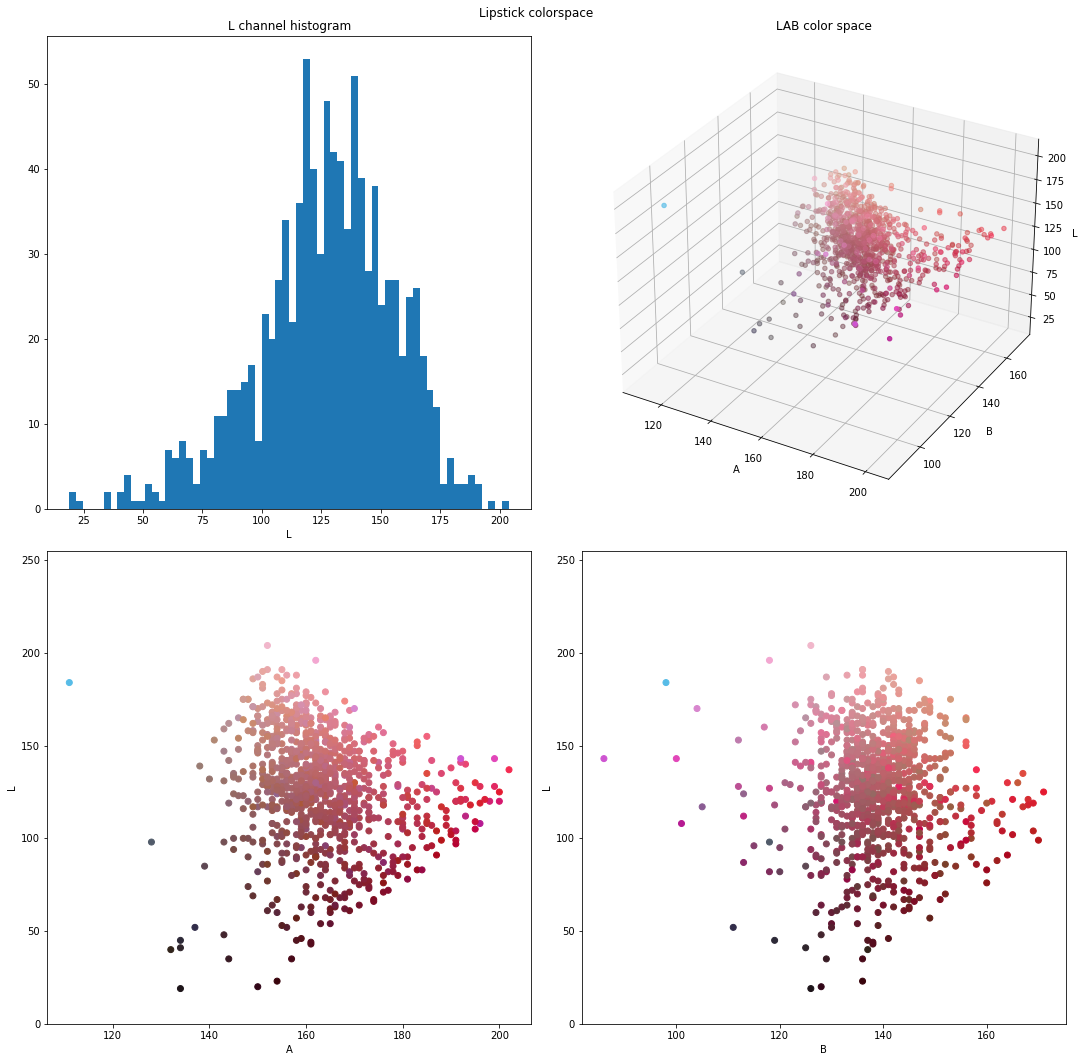

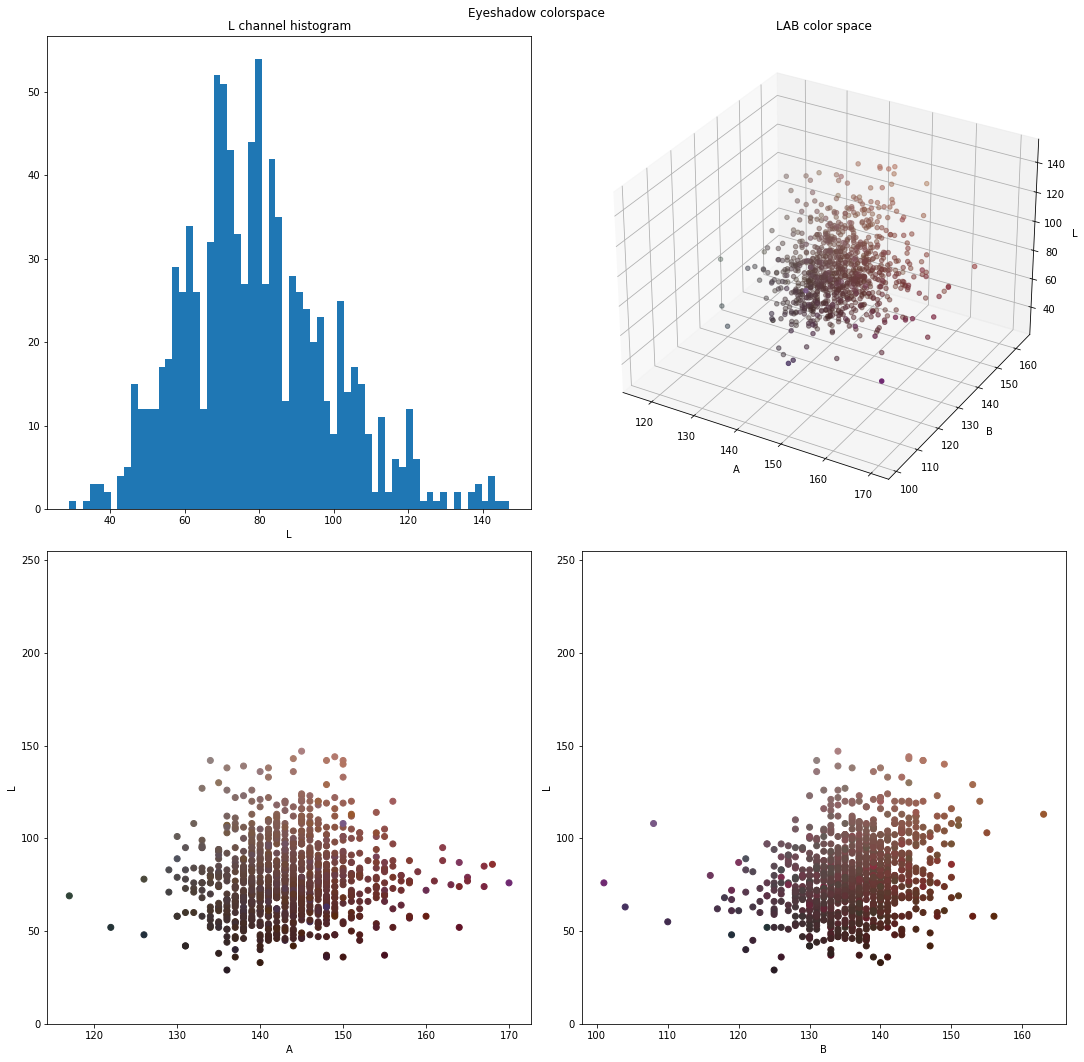

In [10]:
for name, color in parts.items():
    show_colorspace(color, "{} colorspace".format(name.capitalize()))

### Face colors against makeup colors

In [11]:
def show_scatter_matrix(d1, d2, name, scale=15, colors=None):
    plt.figure(figsize=(scale, scale))
    g = sns.PairGrid(pd.concat([d1, d2], axis=1).astype(np.float), x_vars=d2.columns, y_vars=d1.columns, height=scale/3)
    g.map(sns.scatterplot) if colors is None else g.map(sns.scatterplot, c=colors)
    plt.suptitle(name)
    plt.tight_layout()
    plt.show()

<Figure size 1080x1080 with 0 Axes>

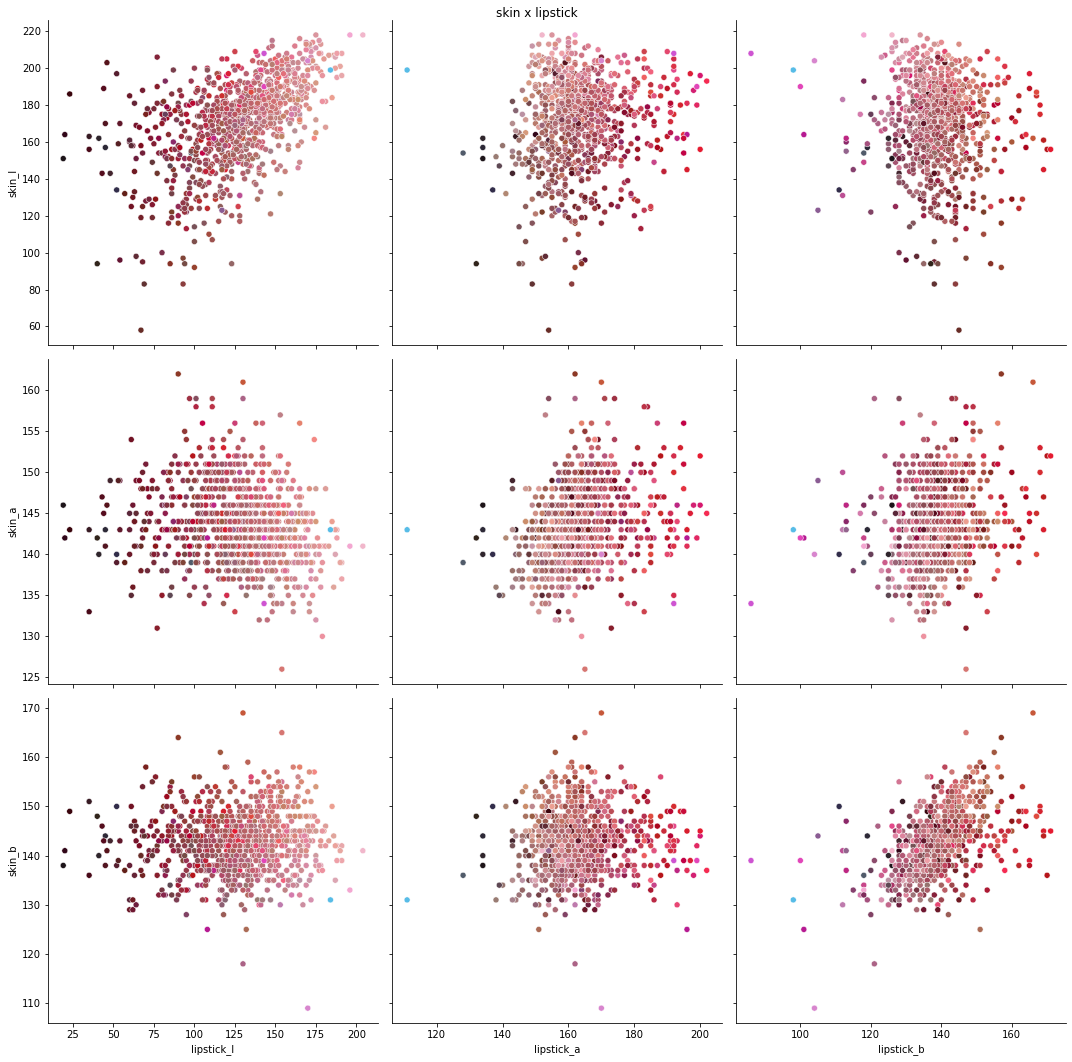

<Figure size 1080x1080 with 0 Axes>

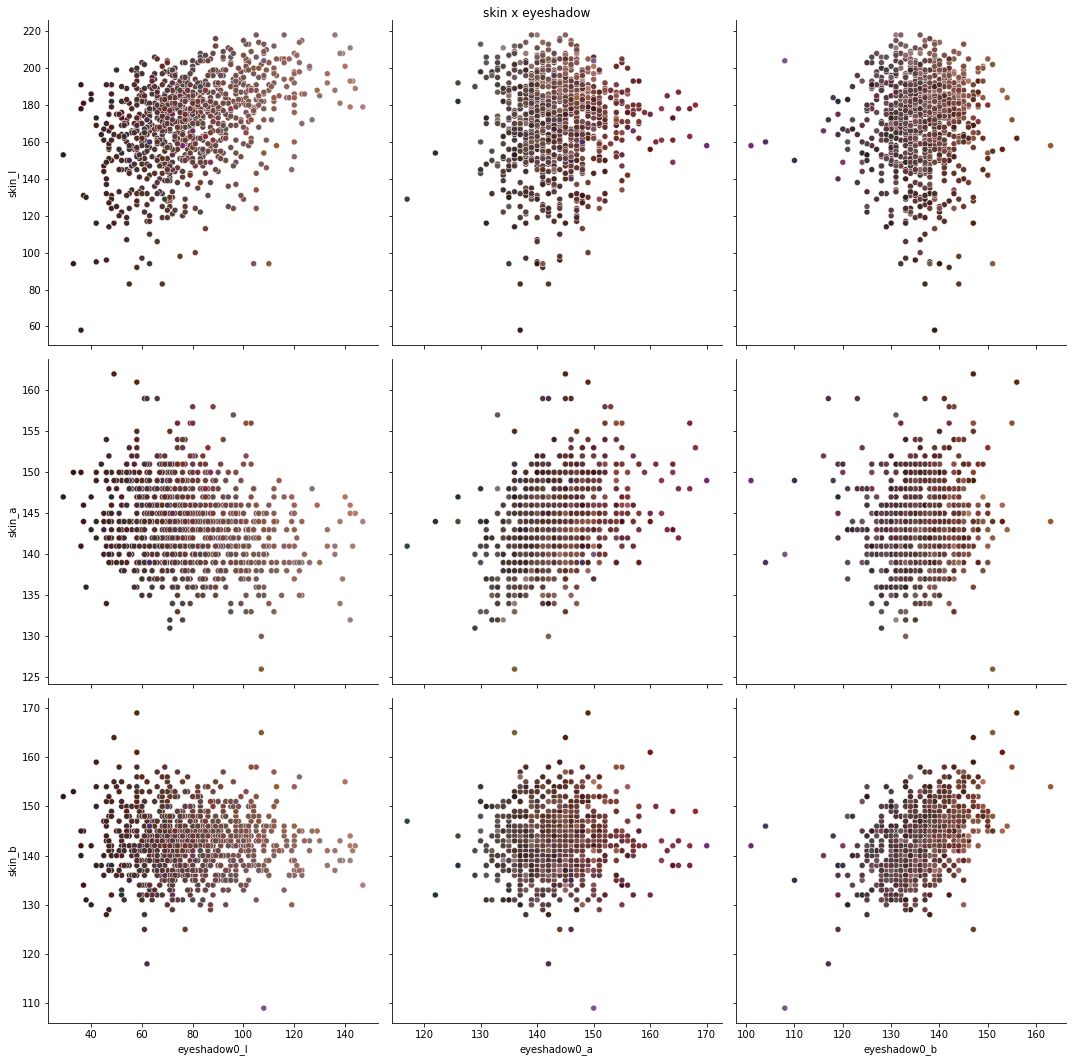

<Figure size 1080x1080 with 0 Axes>

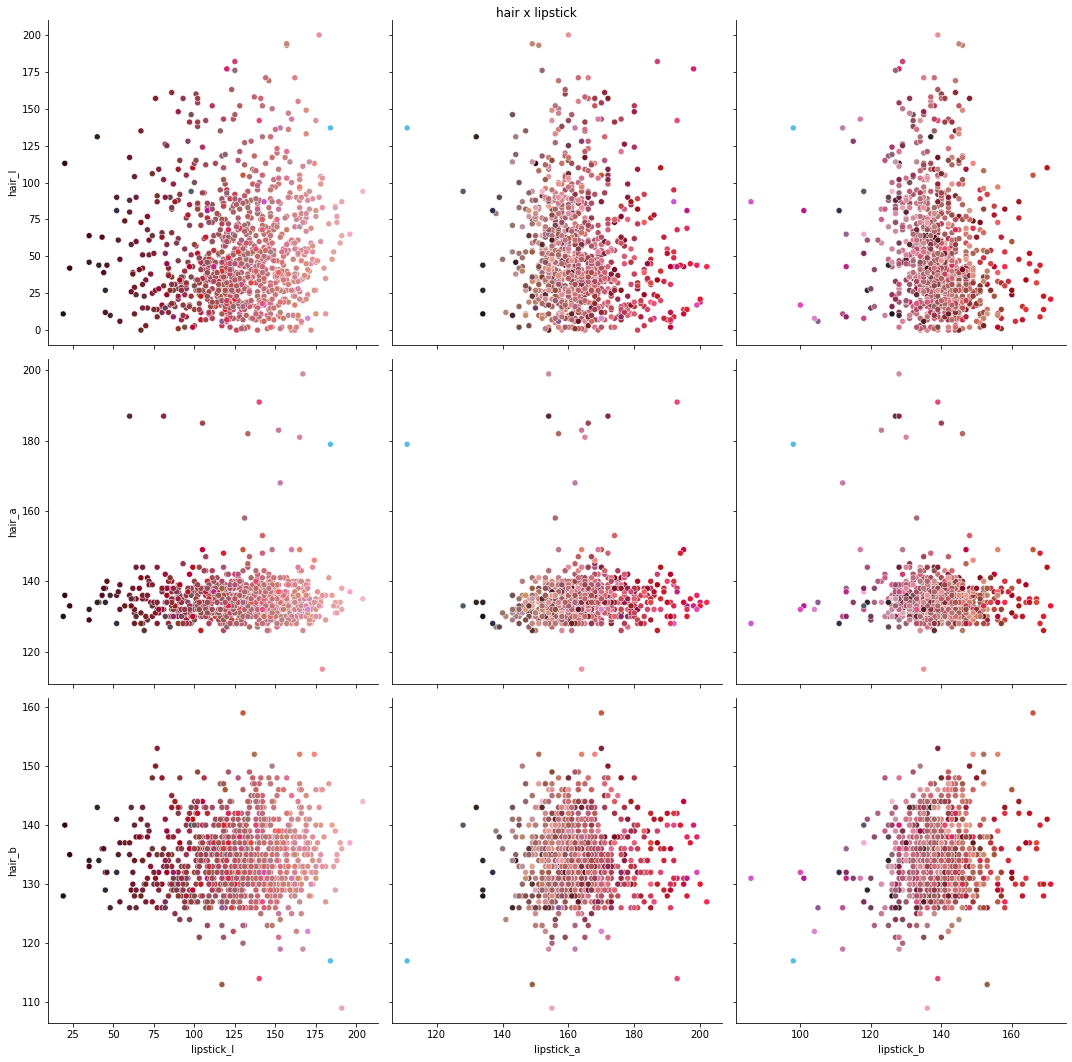

<Figure size 1080x1080 with 0 Axes>

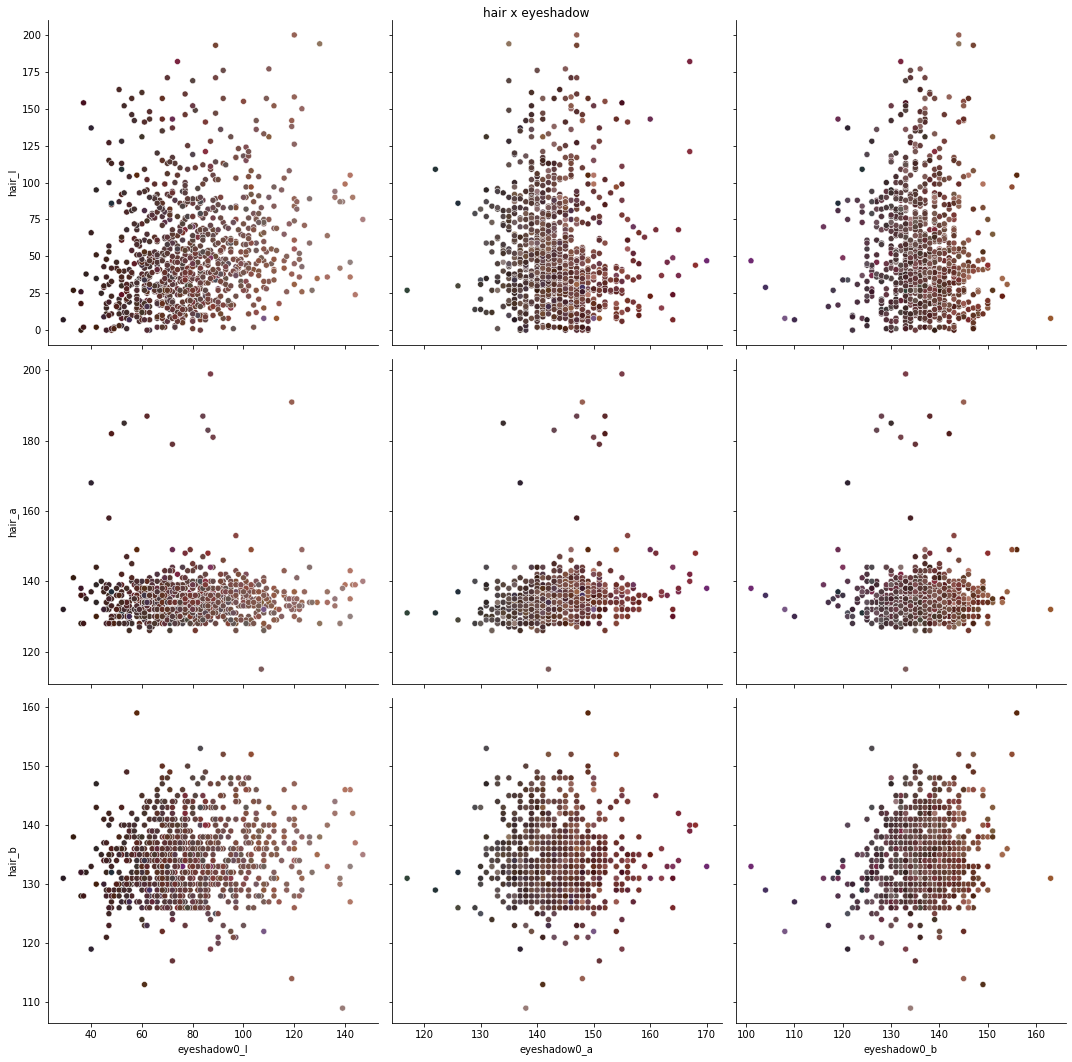

<Figure size 1080x1080 with 0 Axes>

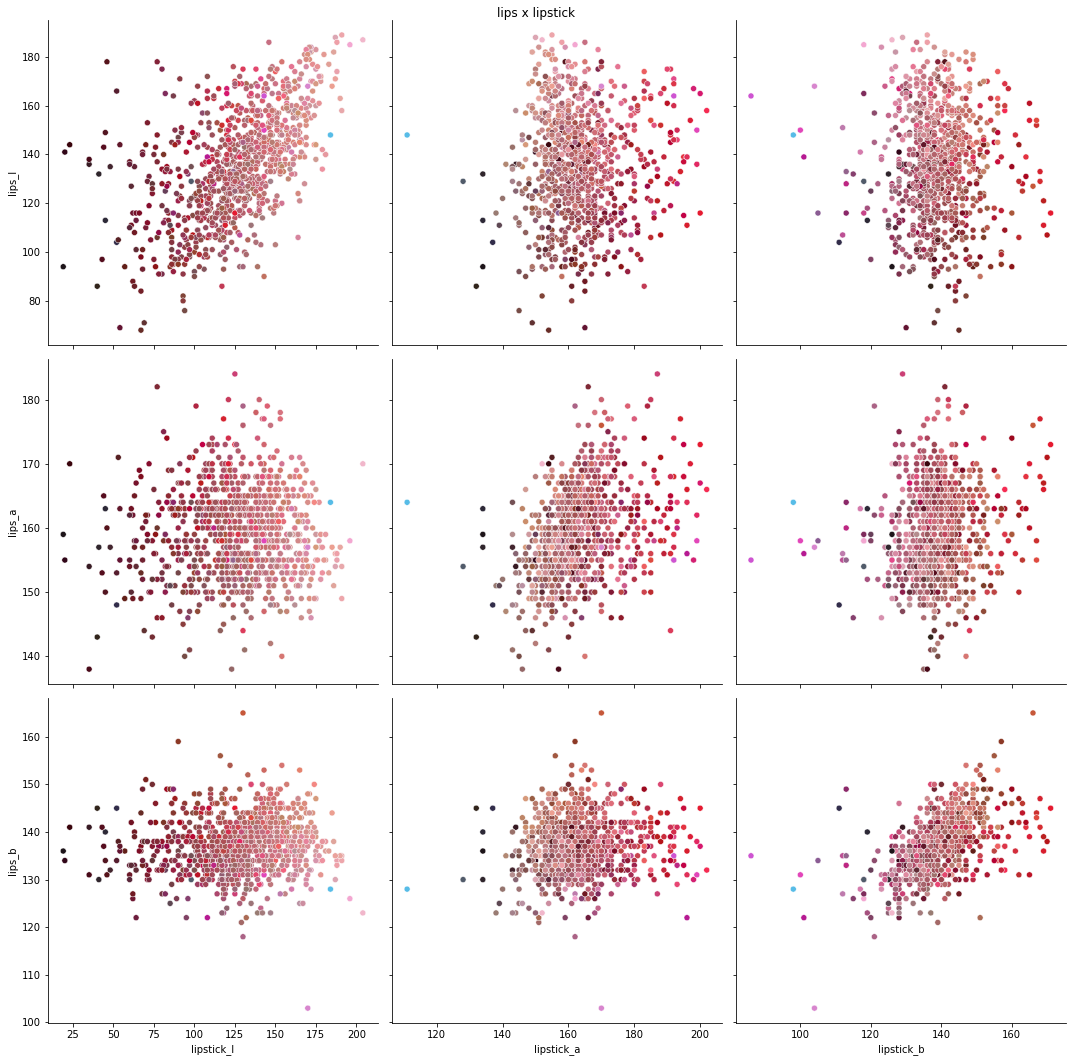

<Figure size 1080x1080 with 0 Axes>

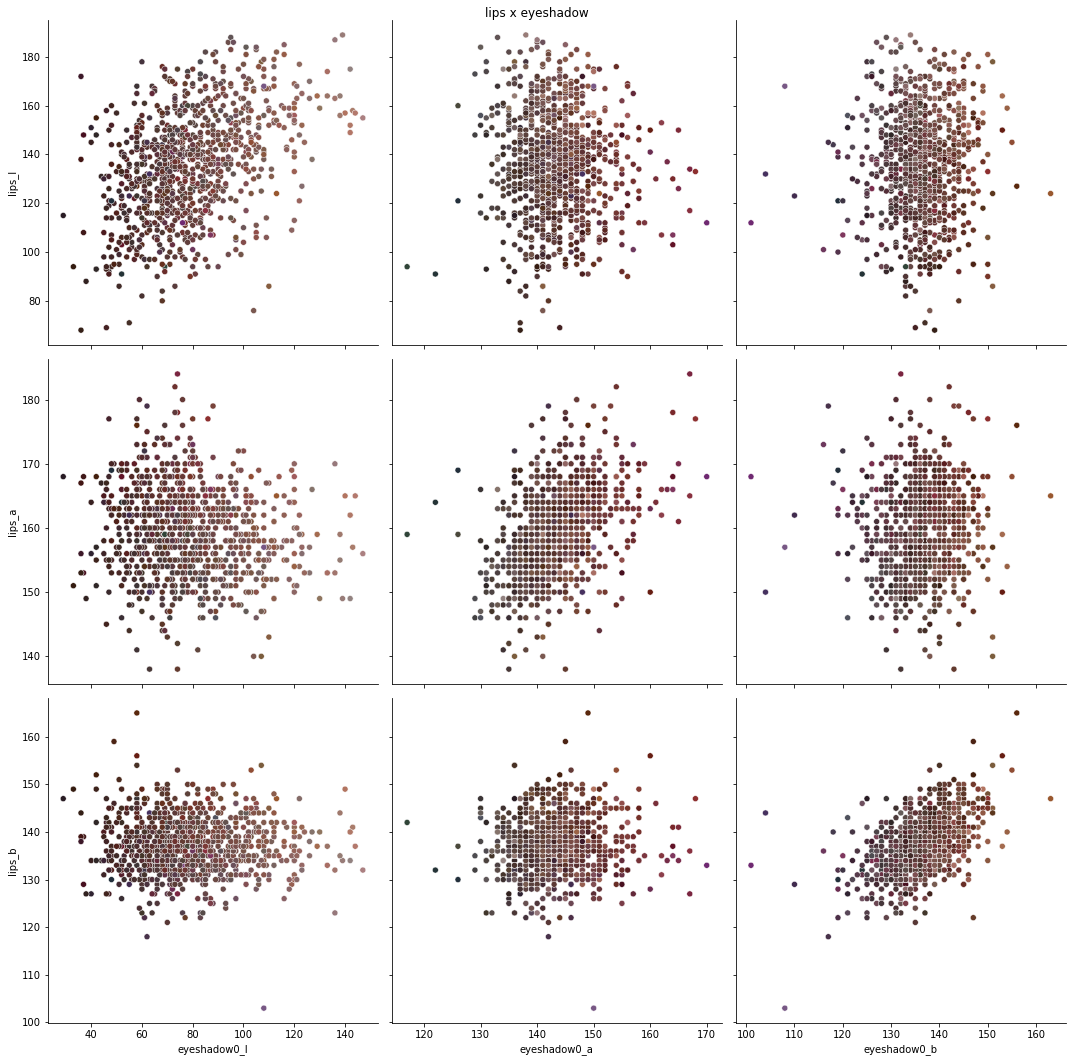

<Figure size 1080x1080 with 0 Axes>

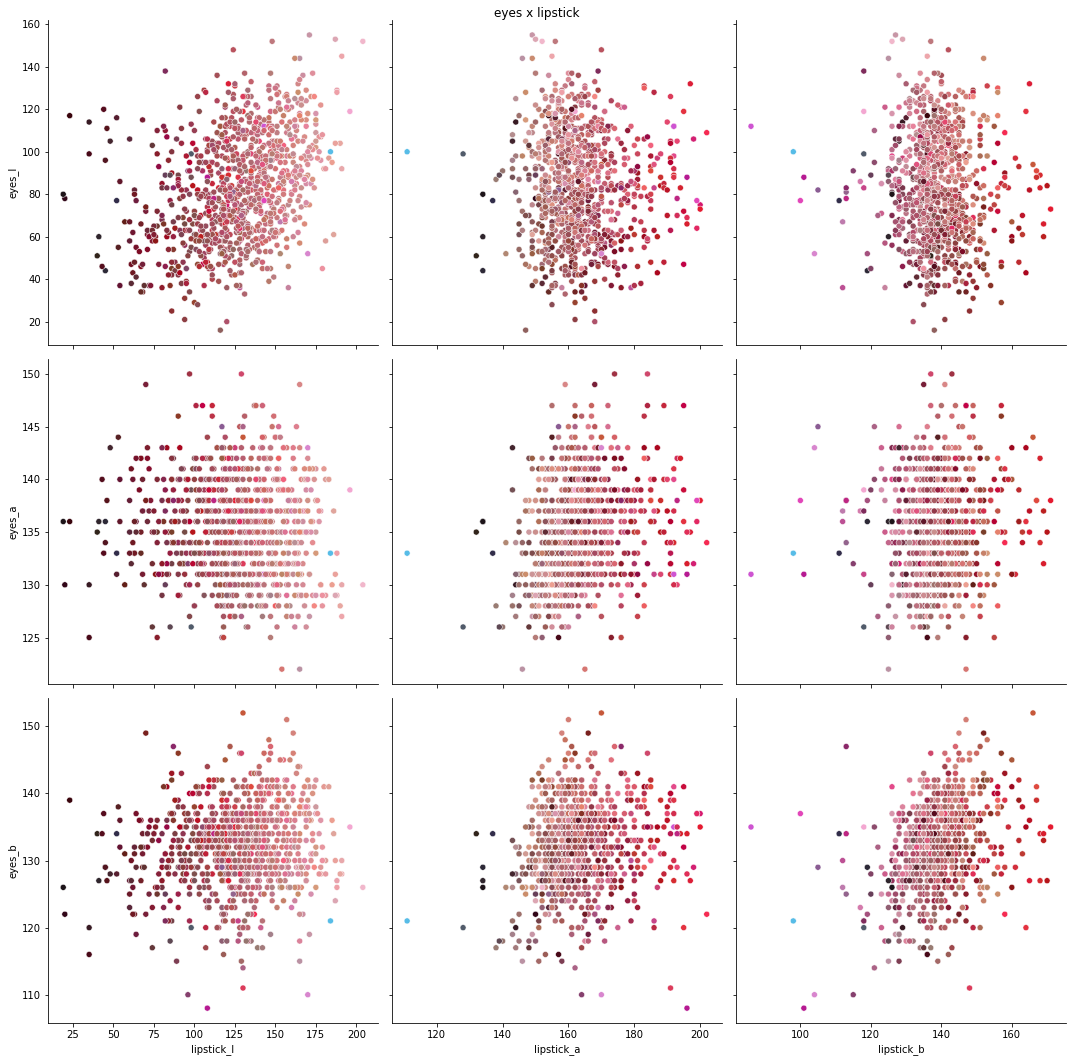

<Figure size 1080x1080 with 0 Axes>

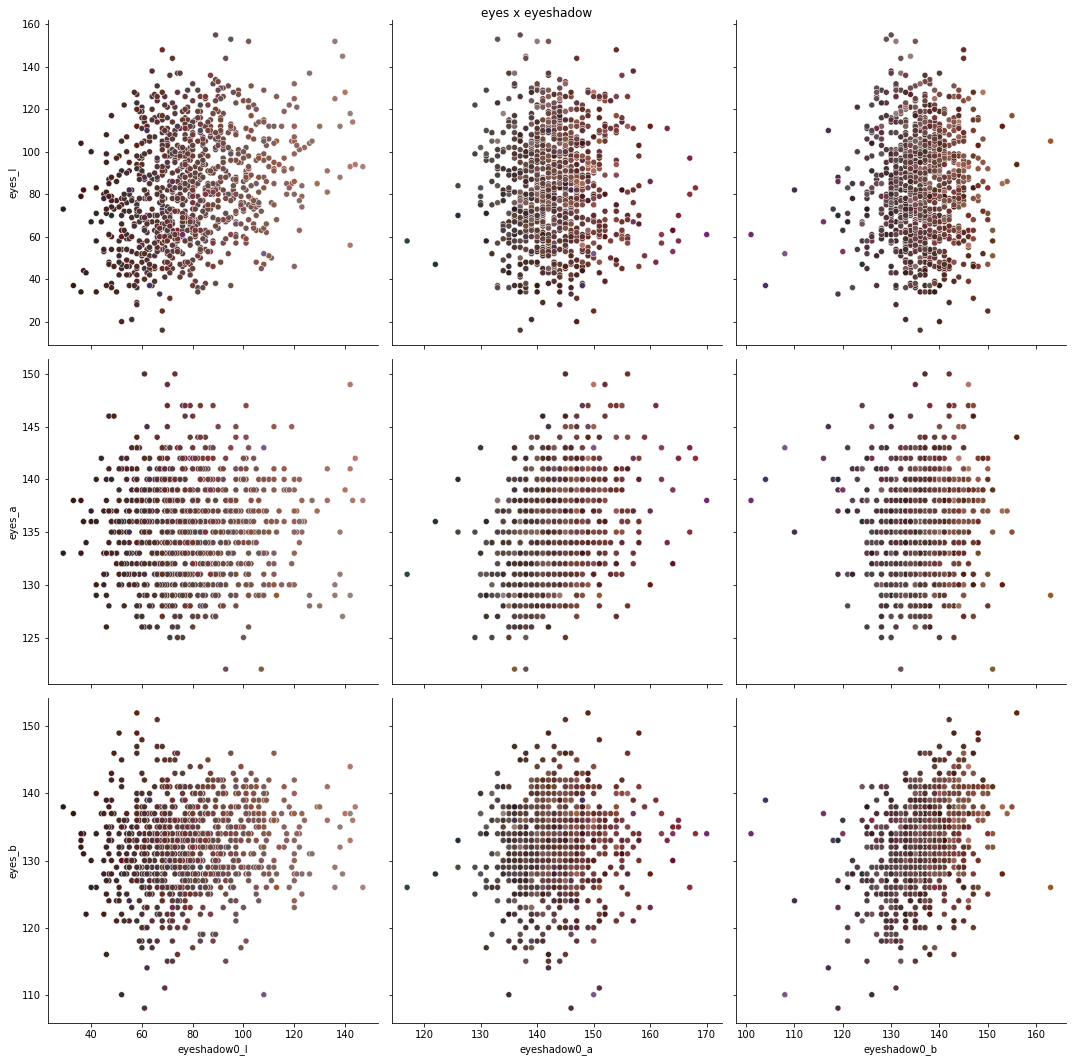

In [12]:
import itertools
for (name1, part1), (name2, part2) in itertools.product(face_lab_parts.items(), makeup_lab_parts.items()):
    show_scatter_matrix(part1, part2, "{} x {}".format(name1, name2), colors=makeup_parts[name2].values/255.)

### Correlations

In [13]:
def show_correlation_heatmap(df, columns_x, columns_y, scale=15):
    fig, (ax, cbar_ax) = plt.subplots(1, 2, figsize=(scale, scale*0.4), gridspec_kw={"width_ratios": (.9, .05)})
    sns.heatmap(df.corr().loc[columns_y, columns_x], vmin=-1, vmax=1, center=0, square=True, ax=ax, cbar_ax=cbar_ax)
    plt.tight_layout()
    plt.show()

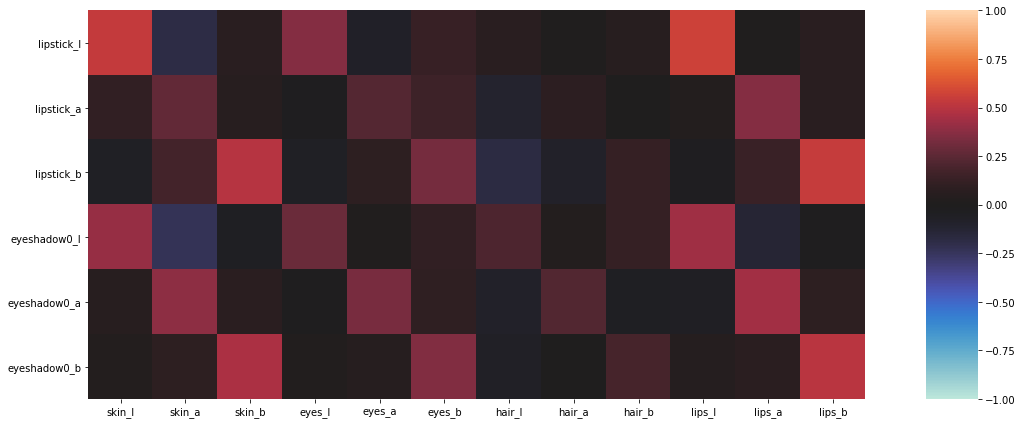

In [14]:
show_correlation_heatmap(pd.concat(lab_parts.values(), axis=1), face_columns_lab, makeup_columns_lab)